In [ ]:
import tensorflow as tf
tf.random.set_seed(1)
tf.compat.v1.enable_eager_execution()

import numpy as np
np.random.seed(1)

import gensim
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, \
    SpatialDropout1D, Bidirectional, Conv1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

%matplotlib inline

In [ ]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
df = pd.read_csv('../data/data.csv')

In [ ]:
df.head()

,word,tag
0,Pengamat,O
1,politik,O
2,dari,O
3,Universitas,B-ORGANIZATION
4,Gadjah,I-ORGANIZATION


In [ ]:
sentences = []
cnt = 1

for i in df.itertuples():
    sentences.append(cnt)
    
    if '.' in str(i.word):
        cnt += 1
        
df['sentence #'] = sentences
df.head()

,word,tag,sentence #
0,Pengamat,O,1
1,politik,O,1
2,dari,O,1
3,Universitas,B-ORGANIZATION,1
4,Gadjah,I-ORGANIZATION,1


In [ ]:
agg_func = lambda s: [(w, t) for w, t in zip(s['word'].values.tolist(), s['tag'].values.tolist())]
grouped = df.groupby('sentence #').apply(agg_func)
sentences = [s for s in grouped]

In [ ]:
words = list(set(df['word'].values))
words.append('PADDING')
num_words = len(words)
tags = list(set(df['tag'].values))
num_tags = len(tags)

In [ ]:
tags = sorted([t for t in tags if t != 'O'], key=lambda x: (x[2], x[0]))
tags.append('O')

In [ ]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
tag2idx

{'B-LOCATION': 0,
 'B-ORGANIZATION': 4,
 'B-PERSON': 8,
 'B-QUANTITY': 12,
 'B-TIME': 16,
 'I-LOCATION': 1,
 'I-ORGANIZATION': 5,
 'I-PERSON': 9,
 'I-QUANTITY': 13,
 'I-TIME': 17,
 'L-LOCATION': 2,
 'L-ORGANIZATION': 6,
 'L-PERSON': 10,
 'L-QUANTITY': 14,
 'L-TIME': 18,
 'O': 20,
 'U-LOCATION': 3,
 'U-ORGANIZATION': 7,
 'U-PERSON': 11,
 'U-QUANTITY': 15,
 'U-TIME': 19}

### Pad Sequence

In [ ]:
max_len = 80
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [ ]:
x_train, x_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=1)

### Pre-trained Word2Vec Embedding

In [ ]:
model = gensim.models.Word2Vec.load("../checkpoint/w2vec_wiki_id_case")

In [ ]:
embedding_matrix = np.zeros((len(words), 400))

for i, w in enumerate(words):
    try:
        embedding_vector = model.wv[w]
        embedding_matrix[i] = embedding_vector
    except:
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), 400)

Initial parameters

In [ ]:
params = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'lstm_units': 100,
    'filters': [128],
    'filter_size': [3],
    'dropout': 0.1,
    'batch_size': 128
}

In [ ]:
def get_report(model, history):
    # plot loss
    fig=plt.figure(figsize=(7,5))
    plt.plot(history.history['loss'], "-o")
    plt.plot(history.history['val_loss'], "-o")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylim(0,1)
    plt.show();
    
    print()
    # plot f1 score
    fig=plt.figure(figsize=(7,5))
    plt.plot(history.history['f1_score_micro'], "-o")
    plt.plot(history.history['val_f1_score_micro'], "-o")
    plt.title('f1_micro')
    plt.xlabel('epoch')
    plt.ylim(0,1)
    plt.show();
    
    print()
    # f1 score micro average
    actuals = np.argmax(np.array(y_test), axis=-1).reshape(-1)
    preds = model.predict(x_test)
    preds = np.argmax(preds, axis=-1).reshape(-1)

    score = f1_score(actuals, preds, average='micro')

    print('f1 score micro average include label O:', score)
    
    print()
    # print classification report
    print(classification_report(actuals, preds, target_names=tags, ))
    
    print()
    # f1 score micro average
    actuals = np.argmax(np.array(y_test), axis=-1).reshape(-1)
    preds = model.predict(x_test)
    preds = np.argmax(preds, axis=-1).reshape(-1)

    o_pad_idx = np.where(actuals==20)

    actuals = np.delete(actuals, o_pad_idx)
    preds = np.delete(preds, o_pad_idx)

    score = f1_score(actuals, preds, average='micro')

    print('f1 score micro average without label O:', score)
    
    print()
    # plot confusion matrix
    fig, ax = plt.subplots(figsize=(10,10))

    cm_matrix = confusion_matrix(actuals, preds)
    cm_matrix = np.delete(cm_matrix, (20), axis=0)
    cm_matrix = np.delete(cm_matrix, (20), axis=1)

    ax.matshow(cm_matrix, cmap=plt.cm.Blues)

    for i in range(num_tags-1):
        for j in range(num_tags-1):
            c = cm_matrix[j,i]
            ax.text(i, j, str(c), va='center', ha='center')

    plt.xticks(range(num_tags-1),['{} ({})'.format(tags[:-1][i],i) for i in range(num_tags-1)])
    plt.yticks(range(num_tags-1),['{} ({})'.format(tags[:-1][i],i) for i in range(num_tags-1)])
    plt.xticks(rotation=90)
    plt.show();

In [ ]:
def f1_score_micro(y_true, y_pred):
    y_true = np.argmax(y_true.numpy(), axis=-1).reshape(-1)
    y_pred = np.argmax(y_pred.numpy(), axis=-1).reshape(-1)
    
    # label O will be ignored during training and evaluation
    o_pad_idx = np.where(y_true==20) # 20 is the idx for label O
    
    # remove label O
    y_true = np.delete(y_true, o_pad_idx)
    y_pred = np.delete(y_pred, o_pad_idx)
    
    # compute f1 score with with micro average
    score = f1_score(y_true, y_pred, average='micro')
    
    return score

In [ ]:
def create_model(params, w2v=False, cnn=False):
    input_sequence = Input(shape=(max_len, ))
    
    # embedding layer
    if w2v:
        model = Embedding(
            input_dim= embedding_matrix.shape[0], 
            weights=[embedding_matrix], 
            output_dim=embedding_matrix.shape[1], 
            input_length=max_len,
            trainable=False
        )(input_sequence)
    else:
        model = Embedding(
            input_dim=num_words,
            output_dim=400,
            input_length=max_len,
        )(input_sequence)
    
    # dropout layer
    model = SpatialDropout1D(0.1)(model)
    
    # convolution layer
    if cnn:
        if len(params['filters']) == 1:
            model = Conv1D(params['filters'][0], params['filter_size'][0], activation='relu', padding='same')(model)
        else:
            cnns = []
            for i, _ in enumerate(params['filters']):
                cnns.append(Conv1D(
                    params['filters'][i], params['filter_size'][i], 
                    activation='relu', padding='same')(model))
            
            model = concatenate(cnns)
            
    # lstm layer
    model = Bidirectional(LSTM(units=100, return_sequences=True))(model)
    
    # output layer
    output_sequence = Dense(num_tags, activation='softmax')(model)
    
    # model
    model = Model(input_sequence, output_sequence)
    
    # learning algorithm (optimizer)
    if params['optimizer'] == 'Nadam':
        optm = tf.keras.optimizers.Nadam(lr=params['lr'])
        
    if params['optimizer'] == 'Adam':
        optm = tf.keras.optimizers.Adam(lr=params['lr'])
        
    if params['optimizer'] == 'RMSprop':
        optm = tf.keras.optimizers.RMSprop(lr=params['lr'])
    
    loss = tf.keras.losses.CategoricalCrossentropy()

    model.compile(loss=loss, optimizer=optm, metrics=[f1_score_micro], run_eagerly=True)
    
    return model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_f1_score_micro', mode='max')

### BiLSTM

In [ ]:
bilstm = create_model(params)

In [ ]:
bilstm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 80, 400)           5212400   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 80, 400)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 200)           400800    
_________________________________________________________________
dense (Dense)                (None, 80, 21)            4221      
Total params: 5,617,421
Trainable params: 5,617,421
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time

bilstm_history = bilstm.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 4s 133ms/step - loss: 0.8326 - f1_score_micro: 0.0035 - val_loss: 0.2520 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 3s 129ms/step - loss: 0.2281 - f1_score_micro: 0.0000e+00 - val_loss: 0.2134 - val_f1_score_micro: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 3s 128ms/step - loss: 0.2049 - f1_score_micro: 0.0000e+00 - val_loss: 0.1987 - val_f1_score_micro: 0.0000e+00
Epoch 4/100
27/27 [==============================] - 4s 130ms/step - loss: 0.1861 - f1_score_micro: 0.0000e+00 - val_loss: 0.1828 - val_f1_score_micro: 0.0000e+00
Epoch 5/100
27/27 [==============================] - 3s 129ms/step - loss: 0.1662 - f1_score_micro: 8.2815e-04 - val_loss: 0.1683 - val_f1_score_micro: 0.0054
Epoch 6/100
27/27 [==============================] - 3s 129ms/step - loss: 0.1482 - f1_score_micro: 0.0319 - val_loss: 0.1573 - val_f1_score_micro: 0.0679
Epoch 7/100
27/27 [===================

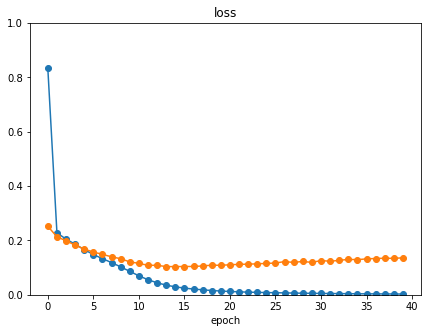

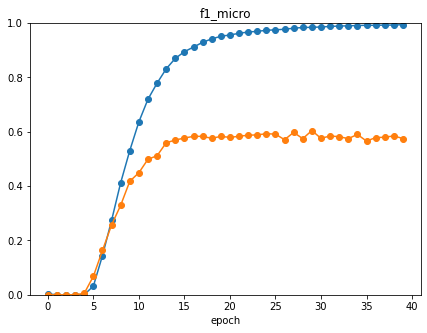


f1 score micro average include label O: 0.9789509536784741

                precision    recall  f1-score   support

    B-LOCATION       0.65      0.58      0.61       104
    I-LOCATION       0.55      0.30      0.39        77
    L-LOCATION       0.71      0.65      0.68       102
    U-LOCATION       0.73      0.71      0.72       239
B-ORGANIZATION       0.71      0.56      0.63       155
I-ORGANIZATION       0.70      0.46      0.56       139
L-ORGANIZATION       0.73      0.56      0.64       157
U-ORGANIZATION       0.80      0.75      0.78       251
      B-PERSON       0.88      0.67      0.76       231
      I-PERSON       0.71      0.52      0.60        62
      L-PERSON       0.86      0.62      0.72       232
      U-PERSON       0.84      0.82      0.83       261
    B-QUANTITY       0.49      0.37      0.42        59
    I-QUANTITY       0.50      0.31      0.38        52
    L-QUANTITY       0.52      0.49      0.50        55
    U-QUANTITY       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6042957455596861



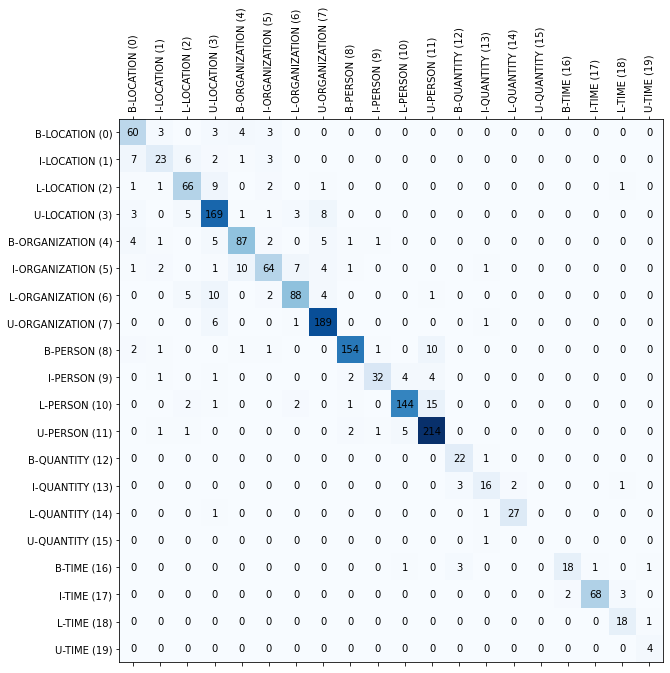

In [ ]:
get_report(bilstm, bilstm_history)

### BiLSTM + w2v

In [ ]:
bilstm_w2v = create_model(params, w2v=True)

In [ ]:
bilstm_w2v.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 400)           5212400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 80, 400)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 200)           400800    
_________________________________________________________________
dense_1 (Dense)              (None, 80, 21)            4221      
Total params: 5,617,421
Trainable params: 405,021
Non-trainable params: 5,212,400
_________________________________________________________________


In [ ]:
%%time

bilstm_w2v_history = bilstm_w2v.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 1s 46ms/step - loss: 0.5122 - f1_score_micro: 0.0034 - val_loss: 0.2376 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 1s 45ms/step - loss: 0.2295 - f1_score_micro: 0.0000e+00 - val_loss: 0.2189 - val_f1_score_micro: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 1s 44ms/step - loss: 0.2187 - f1_score_micro: 0.0000e+00 - val_loss: 0.2120 - val_f1_score_micro: 0.0000e+00
Epoch 4/100
27/27 [==============================] - 1s 46ms/step - loss: 0.2121 - f1_score_micro: 0.0000e+00 - val_loss: 0.2058 - val_f1_score_micro: 0.0000e+00
Epoch 5/100
27/27 [==============================] - 1s 43ms/step - loss: 0.2055 - f1_score_micro: 0.0040 - val_loss: 0.1993 - val_f1_score_micro: 0.0095
Epoch 6/100
27/27 [==============================] - 1s 43ms/step - loss: 0.1986 - f1_score_micro: 0.0102 - val_loss: 0.1932 - val_f1_score_micro: 0.0126
Epoch 7/100
27/27 [=============================

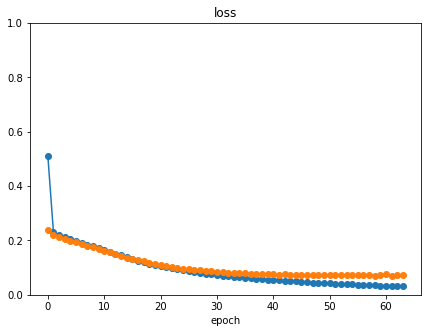

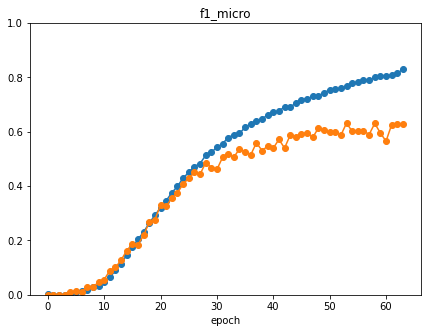


f1 score micro average include label O: 0.9787636239782016

                precision    recall  f1-score   support

    B-LOCATION       0.66      0.57      0.61       104
    I-LOCATION       0.68      0.44      0.54        77
    L-LOCATION       0.75      0.68      0.71       102
    U-LOCATION       0.75      0.66      0.70       239
B-ORGANIZATION       0.56      0.45      0.50       155
I-ORGANIZATION       0.54      0.45      0.49       139
L-ORGANIZATION       0.60      0.54      0.57       157
U-ORGANIZATION       0.69      0.61      0.65       251
      B-PERSON       0.80      0.79      0.80       231
      I-PERSON       0.47      0.61      0.54        62
      L-PERSON       0.84      0.82      0.83       232
      U-PERSON       0.80      0.84      0.82       261
    B-QUANTITY       0.45      0.29      0.35        59
    I-QUANTITY       0.78      0.27      0.40        52
    L-QUANTITY       0.53      0.31      0.39        55
    U-QUANTITY       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6282527881040892



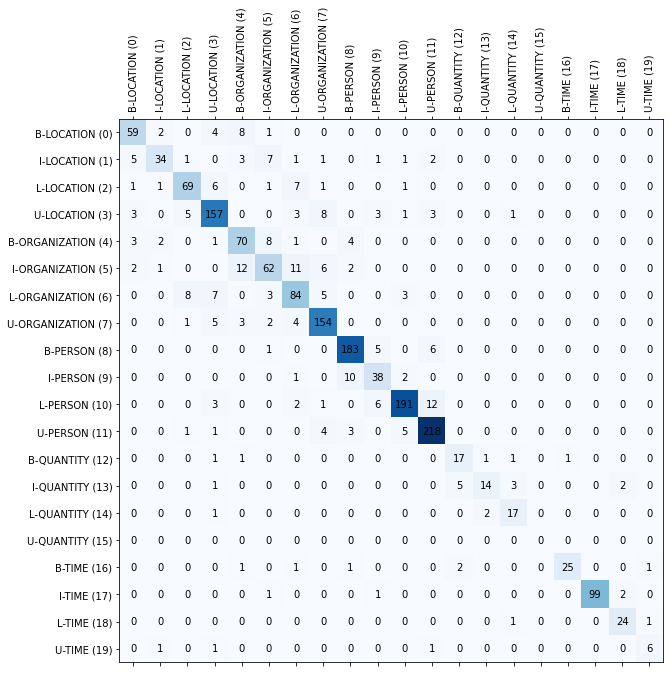

In [ ]:
get_report(bilstm_w2v, bilstm_w2v_history)

### BiLSTM-CNNs

In [ ]:
bilstm_cnns = create_model(params, cnn=True)

In [ ]:
bilstm_cnns.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 80, 400)           5212400   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 80, 400)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 80, 128)           153728    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80, 200)           183200    
_________________________________________________________________
dense_2 (Dense)              (None, 80, 21)            4221      
Total params: 5,553,549
Trainable params: 5,553,549
Non-trainable params: 0
_________________________________________________

In [ ]:
%%time

bilstm_cnns_history = bilstm_cnns.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 4s 132ms/step - loss: 0.7829 - f1_score_micro: 0.0024 - val_loss: 0.2436 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 3s 127ms/step - loss: 0.2287 - f1_score_micro: 0.0000e+00 - val_loss: 0.2139 - val_f1_score_micro: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 3s 124ms/step - loss: 0.2036 - f1_score_micro: 0.0000e+00 - val_loss: 0.1950 - val_f1_score_micro: 0.0000e+00
Epoch 4/100
27/27 [==============================] - 3s 125ms/step - loss: 0.1759 - f1_score_micro: 0.0016 - val_loss: 0.1698 - val_f1_score_micro: 0.0066
Epoch 5/100
27/27 [==============================] - 3s 128ms/step - loss: 0.1432 - f1_score_micro: 0.0799 - val_loss: 0.1550 - val_f1_score_micro: 0.1202
Epoch 6/100
27/27 [==============================] - 3s 124ms/step - loss: 0.1202 - f1_score_micro: 0.2266 - val_loss: 0.1439 - val_f1_score_micro: 0.1931
Epoch 7/100
27/27 [==============================]

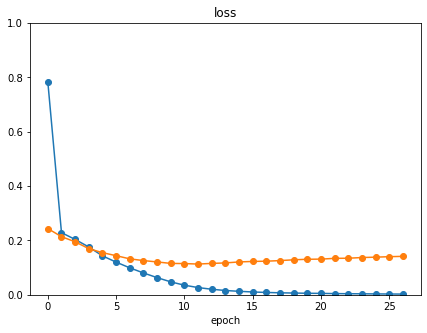

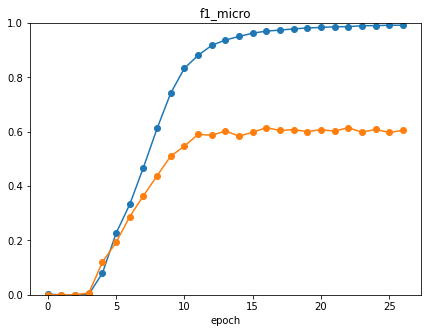


f1 score micro average include label O: 0.9785933242506812

                precision    recall  f1-score   support

    B-LOCATION       0.73      0.63      0.68       104
    I-LOCATION       0.54      0.34      0.42        77
    L-LOCATION       0.72      0.68      0.70       102
    U-LOCATION       0.74      0.65      0.69       239
B-ORGANIZATION       0.77      0.57      0.66       155
I-ORGANIZATION       0.72      0.45      0.56       139
L-ORGANIZATION       0.64      0.60      0.62       157
U-ORGANIZATION       0.80      0.71      0.75       251
      B-PERSON       0.85      0.65      0.74       231
      I-PERSON       0.74      0.50      0.60        62
      L-PERSON       0.86      0.62      0.72       232
      U-PERSON       0.86      0.80      0.83       261
    B-QUANTITY       0.44      0.41      0.42        59
    I-QUANTITY       0.48      0.38      0.43        52
    L-QUANTITY       0.42      0.53      0.47        55
    U-QUANTITY       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6113176373399422



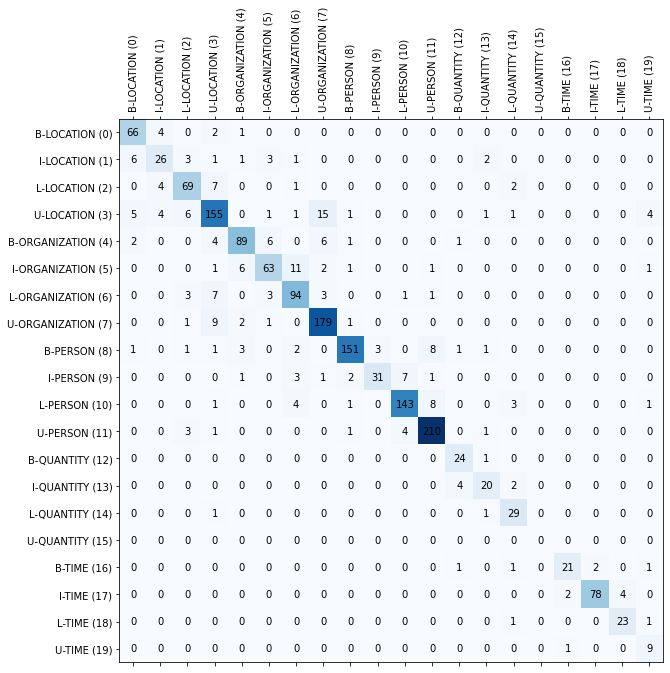

In [ ]:
get_report(bilstm_cnns, bilstm_cnns_history)

### BiLSTM-CNNs + w2v

In [ ]:
bilstm_cnns_w2v = create_model(params, w2v=True, cnn=True)

In [ ]:
bilstm_cnns_w2v.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 80, 400)           5212400   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 80, 400)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 80, 128)           153728    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 80, 200)           183200    
_________________________________________________________________
dense_3 (Dense)              (None, 80, 21)            4221      
Total params: 5,553,549
Trainable params: 341,149
Non-trainable params: 5,212,400
___________________________________________

In [ ]:
%%time

bilstm_cnns_w2v_history = bilstm_cnns_w2v.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 1s 46ms/step - loss: 0.4824 - f1_score_micro: 0.0023 - val_loss: 0.2323 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 1s 43ms/step - loss: 0.2265 - f1_score_micro: 0.0000e+00 - val_loss: 0.2124 - val_f1_score_micro: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 1s 43ms/step - loss: 0.2083 - f1_score_micro: 0.0012 - val_loss: 0.1973 - val_f1_score_micro: 0.0111
Epoch 4/100
27/27 [==============================] - 1s 44ms/step - loss: 0.1921 - f1_score_micro: 0.0123 - val_loss: 0.1816 - val_f1_score_micro: 0.0333
Epoch 5/100
27/27 [==============================] - 1s 43ms/step - loss: 0.1746 - f1_score_micro: 0.0235 - val_loss: 0.1657 - val_f1_score_micro: 0.0499
Epoch 6/100
27/27 [==============================] - 1s 44ms/step - loss: 0.1587 - f1_score_micro: 0.0575 - val_loss: 0.1515 - val_f1_score_micro: 0.0931
Epoch 7/100
27/27 [==============================] - 1s 46ms/ste

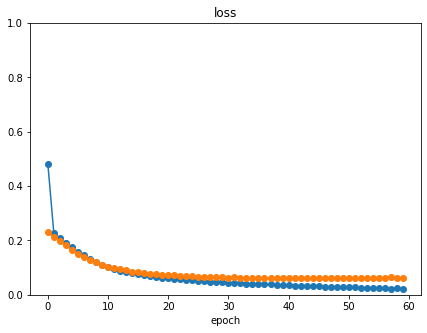

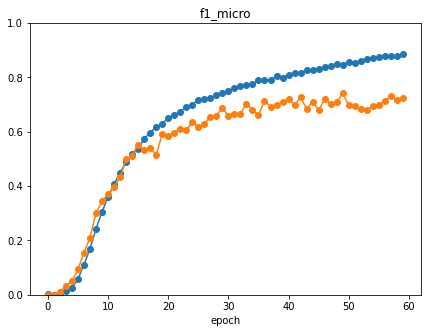


f1 score micro average include label O: 0.9817949591280654

                precision    recall  f1-score   support

    B-LOCATION       0.71      0.67      0.69       104
    I-LOCATION       0.57      0.51      0.54        77
    L-LOCATION       0.74      0.74      0.74       102
    U-LOCATION       0.76      0.78      0.77       239
B-ORGANIZATION       0.66      0.71      0.69       155
I-ORGANIZATION       0.68      0.54      0.60       139
L-ORGANIZATION       0.64      0.70      0.67       157
U-ORGANIZATION       0.71      0.66      0.68       251
      B-PERSON       0.84      0.82      0.83       231
      I-PERSON       0.67      0.65      0.66        62
      L-PERSON       0.87      0.84      0.85       232
      U-PERSON       0.87      0.85      0.86       261
    B-QUANTITY       0.51      0.37      0.43        59
    I-QUANTITY       0.66      0.40      0.50        52
    L-QUANTITY       0.47      0.40      0.43        55
    U-QUANTITY       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6951672862453532



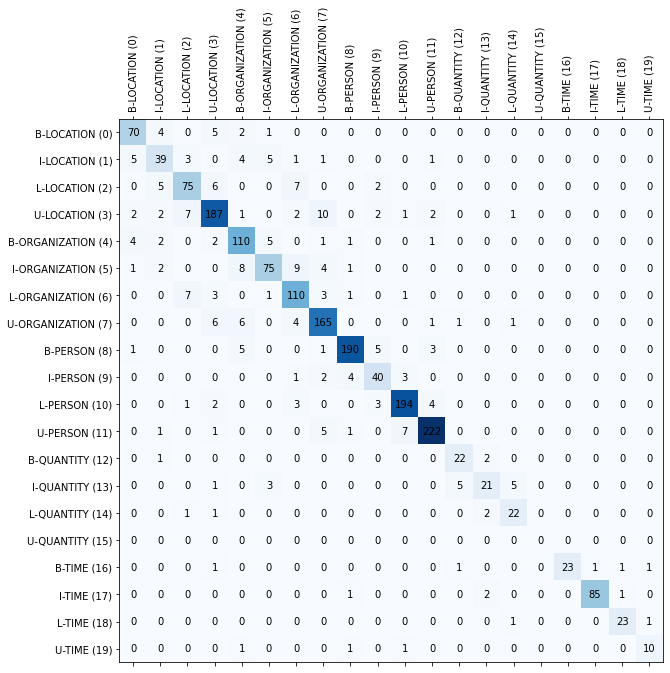

In [ ]:
get_report(bilstm_cnns_w2v, bilstm_cnns_w2v_history)

### BiLSTM-CNNs + multi-sequence n-gram

In [ ]:
multi_cnns_params = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'lstm_units': 100,
    'filters': [128, 128, 128, 128, 128],
    'filter_size': [2, 4, 6, 8, 10],
    'dropout': 0.5,
    'batch_size': 128
}

In [ ]:
bilstm_multi_cnns = create_model(multi_cnns_params, cnn=True)

In [ ]:
bilstm_multi_cnns.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 80, 400)      5212400     input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_4 (SpatialDro (None, 80, 400)      0           embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 80, 128)      102528      spatial_dropout1d_4[0][0]        
____________________________________________________________________________________________

In [ ]:
%%time

bilstm_multi_cnns_history = bilstm_multi_cnns.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=multi_cnns_params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 4s 161ms/step - loss: 0.4971 - f1_score_micro: 0.0015 - val_loss: 0.2324 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 4s 145ms/step - loss: 0.2134 - f1_score_micro: 0.0000e+00 - val_loss: 0.1965 - val_f1_score_micro: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 4s 142ms/step - loss: 0.1787 - f1_score_micro: 0.0042 - val_loss: 0.1654 - val_f1_score_micro: 0.0144
Epoch 4/100
27/27 [==============================] - 4s 145ms/step - loss: 0.1347 - f1_score_micro: 0.1223 - val_loss: 0.1385 - val_f1_score_micro: 0.2105
Epoch 5/100
27/27 [==============================] - 4s 146ms/step - loss: 0.0966 - f1_score_micro: 0.3738 - val_loss: 0.1182 - val_f1_score_micro: 0.3561
Epoch 6/100
27/27 [==============================] - 4s 143ms/step - loss: 0.0627 - f1_score_micro: 0.6169 - val_loss: 0.1054 - val_f1_score_micro: 0.4962
Epoch 7/100
27/27 [==============================] - 4s 14

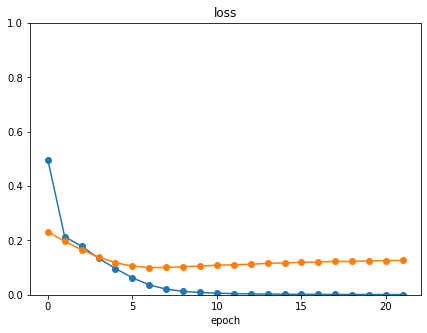

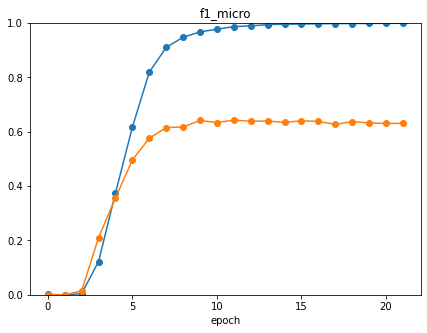


f1 score micro average include label O: 0.980074931880109

                precision    recall  f1-score   support

    B-LOCATION       0.69      0.59      0.63       104
    I-LOCATION       0.49      0.36      0.42        77
    L-LOCATION       0.71      0.70      0.70       102
    U-LOCATION       0.78      0.69      0.73       239
B-ORGANIZATION       0.70      0.65      0.67       155
I-ORGANIZATION       0.78      0.50      0.61       139
L-ORGANIZATION       0.73      0.62      0.67       157
U-ORGANIZATION       0.81      0.73      0.77       251
      B-PERSON       0.87      0.66      0.75       231
      I-PERSON       0.68      0.65      0.66        62
      L-PERSON       0.91      0.64      0.75       232
      U-PERSON       0.85      0.82      0.83       261
    B-QUANTITY       0.48      0.37      0.42        59
    I-QUANTITY       0.57      0.50      0.53        52
    L-QUANTITY       0.40      0.45      0.43        55
    U-QUANTITY       0.00      0.00      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6406443618339529



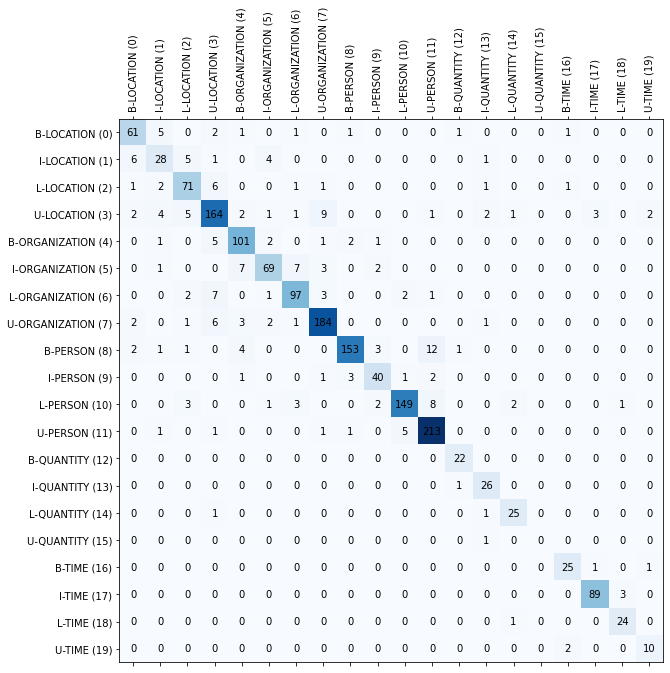

In [ ]:
get_report(bilstm_multi_cnns, bilstm_multi_cnns_history)

### BiLSTM-CNNs + multi-sequence n-gram + w2v

In [ ]:
bilstm_multi_cnns_w2v = create_model(multi_cnns_params, w2v=True, cnn=True)

In [ ]:
bilstm_multi_cnns_w2v.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 80, 400)      5212400     input_6[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 80, 400)      0           embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 80, 128)      102528      spatial_dropout1d_5[0][0]        
____________________________________________________________________________________________

In [ ]:
%%time

bilstm_multi_cnns_w2v_history = bilstm_multi_cnns_w2v.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=multi_cnns_params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 2s 73ms/step - loss: 0.3690 - f1_score_micro: 0.0011 - val_loss: 0.2131 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 2s 70ms/step - loss: 0.2057 - f1_score_micro: 0.0057 - val_loss: 0.1908 - val_f1_score_micro: 0.0164
Epoch 3/100
27/27 [==============================] - 2s 72ms/step - loss: 0.1796 - f1_score_micro: 0.0192 - val_loss: 0.1650 - val_f1_score_micro: 0.0444
Epoch 4/100
27/27 [==============================] - 2s 70ms/step - loss: 0.1538 - f1_score_micro: 0.0863 - val_loss: 0.1460 - val_f1_score_micro: 0.1600
Epoch 5/100
27/27 [==============================] - 2s 71ms/step - loss: 0.1356 - f1_score_micro: 0.1637 - val_loss: 0.1305 - val_f1_score_micro: 0.1972
Epoch 6/100
27/27 [==============================] - 2s 70ms/step - loss: 0.1190 - f1_score_micro: 0.2576 - val_loss: 0.1172 - val_f1_score_micro: 0.2690
Epoch 7/100
27/27 [==============================] - 2s 70ms/step - loss

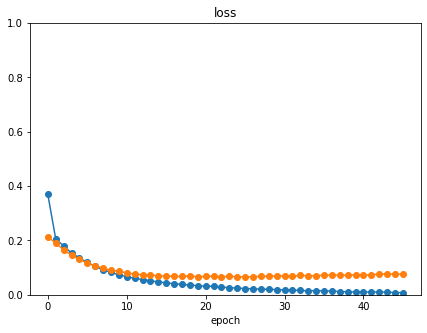

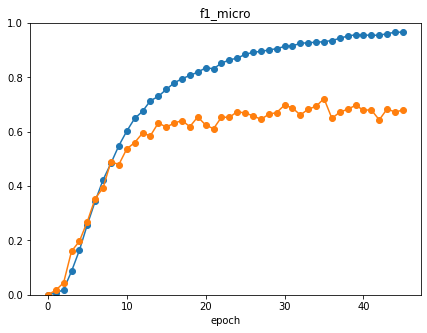


f1 score micro average include label O: 0.9798194822888283

                precision    recall  f1-score   support

    B-LOCATION       0.72      0.61      0.66       104
    I-LOCATION       0.46      0.47      0.46        77
    L-LOCATION       0.67      0.73      0.70       102
    U-LOCATION       0.76      0.72      0.74       239
B-ORGANIZATION       0.68      0.61      0.64       155
I-ORGANIZATION       0.61      0.41      0.49       139
L-ORGANIZATION       0.62      0.51      0.56       157
U-ORGANIZATION       0.71      0.61      0.66       251
      B-PERSON       0.82      0.83      0.82       231
      I-PERSON       0.53      0.74      0.62        62
      L-PERSON       0.82      0.85      0.84       232
      U-PERSON       0.86      0.79      0.82       261
    B-QUANTITY       0.39      0.24      0.29        59
    I-QUANTITY       0.71      0.38      0.50        52
    L-QUANTITY       0.55      0.40      0.46        55
    U-QUANTITY       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6517967781908303



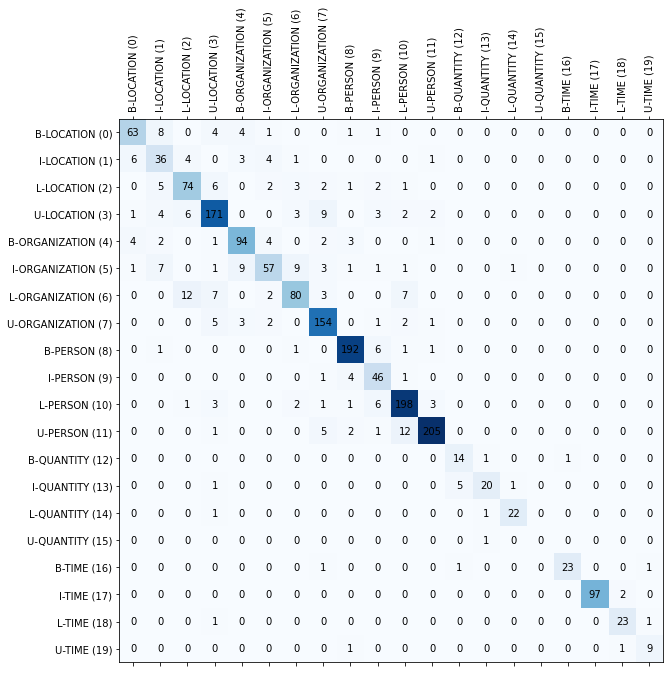

In [ ]:
get_report(bilstm_multi_cnns_w2v, bilstm_multi_cnns_w2v_history)